In [1]:
import datetime as dt

import matplotlib.pyplot as plt

import pandas as pd

import pydotplus

from IPython.display import Image

from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with statistically assigned labels)

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)
customer_profile.head()

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items
0,12347,366,2,103,676,584.91,1.380272,0.019126,11.775956,6.715847
1,12348,283,75,21,1248,298.50,0.869069,0.014134,5.078587,8.240283
2,12349,1,19,72,630,1457.55,0.000000,1.000000,1457.550000,630.000000
3,12350,1,310,16,196,294.40,0.000000,1.000000,294.400000,196.000000
4,12352,261,36,57,125,226.25,1.090060,0.026820,5.309349,2.015326


In [3]:
ranges_m = [0.4, 0.85]
quantiles_m = customer_profile.quantile(q=ranges_m)
quantiles_m

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items
0.40,14703.40,30.4,33.0,26.0,180.0,229.592,0.000000,0.030769,10.669286,6.09503
0.85,17391.85,309.0,218.0,111.0,557.7,514.417,1.220749,1.000000,310.597500,176.00000


In [4]:
#ranges_f = [0.3, 0.7]
#quantiles_f = customer_profile.quantile(q=ranges_f)
#quantiles_f

In [5]:
ranges_r = [0.3, 0.66]
quantiles_r = customer_profile.quantile(q=ranges_r)
quantiles_r

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items
0.30,14109.30,1.0,22.0,19.0,139.00,189.4150,0.000000,0.023256,7.145611,4.056032
0.66,16242.86,201.0,88.0,57.0,323.86,348.2043,0.693147,1.000000,95.234222,42.000000


In [6]:
def ScoreM(x, data, thresh):
    if x <= thresh[data][ranges_m[0]]:
        return 1
    elif x <= thresh[data][ranges_m[1]]:
        return 2
    else:
        return 3

'''def ScoreF(x, data, thresh):
    if x <= thresh[data][ranges_f[0]]:
        return 1
    elif x <= thresh[data][ranges_f[1]]:
        return 2
    else:
        return 3'''

def ScoreR(x, data, thresh):
    if x <= thresh[data][ranges_r[0]]:
        return 3
    elif x <= thresh[data][ranges_r[1]]:
        return 2
    else:
        return 1

In [7]:
customer_profile['MScore'] = customer_profile['RMonetary'].apply(ScoreM, args=('RMonetary', quantiles_m))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r))
customer_profile['Score'] = (0.5 * customer_profile['MScore']
                           + 0.25 * customer_profile['RScore'])
customer_profile.describe()

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items,MScore,RScore,Score
count,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000,4322.000000
mean,15298.978019,131.578205,92.627487,61.469227,363.978714,352.605443,0.549824,0.398360,140.404640,87.795408,1.750116,1.962749,1.365745
std,1721.281691,132.118478,100.082801,85.391008,660.560229,352.138831,0.540037,0.492011,304.371938,243.122858,0.698483,0.799068,0.360051
min,12347.000000,1.000000,1.000000,1.000000,1.000000,2.900000,0.000000,0.005464,0.111125,0.075829,1.000000,1.000000,0.750000
25%,13812.250000,1.000000,18.000000,16.000000,121.000000,168.428750,0.000000,0.020164,5.855877,3.342782,1.000000,1.000000,1.000000
50%,15296.500000,94.000000,51.000000,35.000000,224.000000,286.817500,0.597765,0.045455,16.503148,9.512905,2.000000,2.000000,1.250000
75%,16778.750000,253.000000,142.750000,77.000000,406.750000,406.285000,1.013336,1.000000,174.270000,94.000000,2.000000,3.000000,1.750000
max,18287.000000,374.000000,374.000000,1785.000000,15049.000000,4873.810000,1.772946,2.000000,4873.810000,7824.000000,3.000000,3.000000,2.250000


In [8]:
ranges = [0.25, 0.8]
quantiles = customer_profile.quantile(q=ranges)
quantiles

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items,MScore,RScore,Score
0.25,13812.25,1.0,18.0,16.0,121.0,168.42875,0.000000,0.020164,5.855877,3.342782,1.0,1.0,1.00
0.80,17079.80,278.0,179.0,92.0,472.0,449.79400,1.075414,1.000000,230.370000,132.000000,2.0,3.0,1.75


In [9]:
def Score(x, data, thresh):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [10]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles))
customer_labeled.head()

df_majority = customer_labeled[customer_labeled.Label == 'Medium']
df_minority = customer_labeled[customer_labeled.Label == 'High']
df_middle   = customer_labeled[customer_labeled.Label == 'Low']

customer_labeled.Label.value_counts()

Medium    2900
Low       1104
High       318
Name: Label, dtype: int64

In [11]:
# Upsample minority classes

df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))

df_middle_upsampled = resample(df_middle,
                               replace=True,
                               n_samples=len(df_majority))

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
customer_labeled = df_upsampled
df_upsampled.Label.value_counts()

Low       2900
Medium    2900
High      2900
Name: Label, dtype: int64

In [12]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize

def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [13]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore 
customer_labeled = customer_labeled[['Recency', 'RFrequency', 'Label_num']]

label = customer_labeled.pop('Label_num')

scaler = StandardScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_labeled, label, stratify=label, test_size=0.3)

In [14]:
train_label.head()

2628    0
4048    2
3652    0
183     1
3216    2
Name: Label_num, dtype: int64

## Decision Tree

In [51]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=4,
                                  min_samples_split=3, min_samples_leaf=10)

dec_t = dec_t.fit(train_set, train_label)

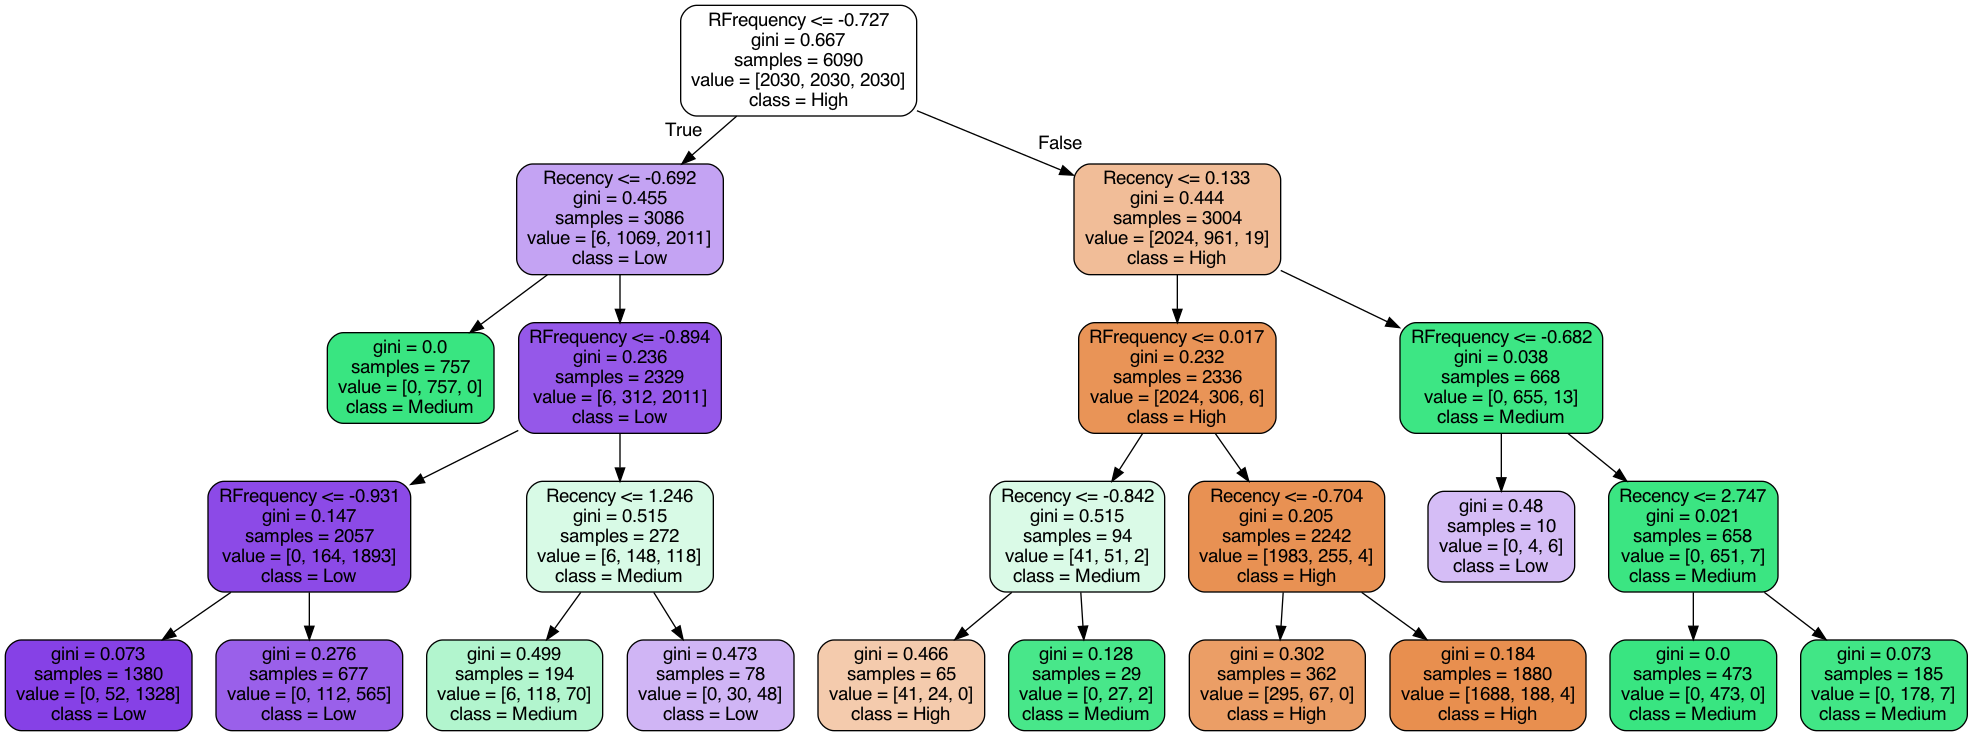

In [52]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Recency', 'RFrequency'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [53]:
# Predict phase

train_pred_dt = dec_t.predict(train_set)
test_pred_dt = dec_t.predict(test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [54]:
# Evaulate the accuracy and F1 score on the train set and the test set

print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred_dt))
print()
print('F1 score train set:', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('F1 score test set: ', metrics.f1_score(test_label, test_pred_dt, average='weighted'))

#print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set: 0.9070607553366175
Accuracy test set:  0.8961685823754789

F1 score train set: 0.9042805584444722
F1 score test set:  0.8928541278772238


In [65]:
from sklearn.metrics import classification_report

print('Train:')
print(classification_report(train_label, 
                            train_pred_dt, 
                            target_names=['High', 'Medium','Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label, 
                            test_pred_dt, 
                            target_names=['High', 'Medium','Low']))

Train:
              precision    recall  f1-score   support

        High       0.88      1.00      0.93      2030
      Medium       0.95      0.77      0.85      2030
         Low       0.91      0.96      0.93      2030

    accuracy                           0.91      6090
   macro avg       0.91      0.91      0.90      6090
weighted avg       0.91      0.91      0.90      6090

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.89      1.00      0.94       870
      Medium       0.93      0.75      0.83       870
         Low       0.88      0.95      0.91       870

    accuracy                           0.90      2610
   macro avg       0.90      0.90      0.89      2610
weighted avg       0.90      0.90      0.89      2610



In [33]:
# cross validation
# the score array for test/train scores on each cv split
# the time for fitting/scoring the estimator on the train set for each cv split

from sklearn.model_selection import cross_validate
import statistics 

scores = cross_validate(dec_t, train_set, train_label, cv=3, return_train_score=True)

print('Fit time:   ', statistics.mean(scores['fit_time']))
print('Score time: ', statistics.mean(scores['score_time']))
print('Test score: ', statistics.mean(scores['test_score']))
print('Train score:', statistics.mean(scores['train_score']))

Fit time:    0.003348668416341146
Score time:  0.0008296171824137369
Test score:  0.9021346469622331
Train score: 0.9074712643678161


In [64]:
# compute confusion matrix

from sklearn.metrics import confusion_matrix

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[2024    6    0]
 [ 279 1553  198]
 [   4   79 1947]]
------------------
Test:
[[866   4   0]
 [110 649 111]
 [  1  45 824]]


## SVM

In [66]:
from sklearn.svm import SVC

svm = SVC(kernel='poly', C=0.5, gamma='scale')
svm.fit(train_set, train_label)

SVC(C=0.5, kernel='poly')

In [67]:
# Predictions

train_pred_svm = svm.predict(train_set)
test_pred_svm = svm.predict(test_set)

In [68]:
# Compute the performance of the model

print('Train:')
print(classification_report(train_label, 
                            train_pred_svm, 
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=['High', 'Medium', 'Low']))

Train:
              precision    recall  f1-score   support

        High       0.85      0.97      0.91      2030
      Medium       0.88      0.71      0.78      2030
         Low       0.88      0.93      0.90      2030

    accuracy                           0.87      6090
   macro avg       0.87      0.87      0.87      6090
weighted avg       0.87      0.87      0.87      6090

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.86      0.97      0.91       870
      Medium       0.87      0.71      0.78       870
         Low       0.88      0.93      0.90       870

    accuracy                           0.87      2610
   macro avg       0.87      0.87      0.86      2610
weighted avg       0.87      0.87      0.86      2610



## KNN

In [69]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [70]:
train_pred_knn = knn.predict(train_set)
test_pred_knn = knn.predict(test_set)

In [71]:
print('Train:')
print(classification_report(train_label, 
                            train_pred_knn, 
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label, 
                            test_pred_knn, 
                            target_names=['High', 'Medium', 'Low']))

Train:
              precision    recall  f1-score   support

        High       0.89      0.99      0.94      2030
      Medium       0.96      0.81      0.88      2030
         Low       0.93      0.98      0.96      2030

    accuracy                           0.93      6090
   macro avg       0.93      0.93      0.92      6090
weighted avg       0.93      0.93      0.92      6090

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.89      0.99      0.94       870
      Medium       0.94      0.77      0.85       870
         Low       0.89      0.96      0.93       870

    accuracy                           0.91      2610
   macro avg       0.91      0.91      0.90      2610
weighted avg       0.91      0.91      0.90      2610



## Classification with Random Forest

In [73]:
# Define and fit a random forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 

rf = rf.fit(train_set, train_label)

In [74]:
train_pred_rf = rf.predict(train_set)
test_pred_rf = rf.predict(test_set)

In [75]:
print('Train:')
print(classification_report(train_label, 
                            train_pred_rf, 
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label, 
                            test_pred_rf, 
                            target_names=['High', 'Medium', 'Low']))

Train:
              precision    recall  f1-score   support

        High       0.88      1.00      0.93      2030
      Medium       0.95      0.77      0.85      2030
         Low       0.91      0.96      0.93      2030

    accuracy                           0.91      6090
   macro avg       0.91      0.91      0.91      6090
weighted avg       0.91      0.91      0.91      6090

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.89      1.00      0.94       870
      Medium       0.93      0.75      0.83       870
         Low       0.88      0.95      0.92       870

    accuracy                           0.90      2610
   macro avg       0.90      0.90      0.89      2610
weighted avg       0.90      0.90      0.89      2610

